In this notebook, we take our first shot at comparing an ELO model to the odds model, and looking at the biggest mistakes the ELO model makes!

In [2]:
from tennis_new.model.config.elo.hardcourt import HardCourtELO

hard = HardCourtELO()

In [3]:
from tennis_new.fetch.get_joined import read_joined

jd = read_joined() 
assert jd['tourney_surface'].notnull().all()

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [4]:
to_fit = jd[jd['score'].notnull()]  # Don't fit on weird matches with scores missing
to_fit = to_fit[to_fit['score'].map(lambda x: 'RET' not in x)]  # Don't fit on matches where one player retired
to_fit = to_fit[to_fit['score'].map(lambda x: 'W/O' not in x)]  # Don't fit on walkovers

In [5]:
with_score = jd[jd['score'].notnull()]
with_score[with_score['score'].map(lambda x: 'W/O' in x)][[
    'winner_name',
    'loser_name',
    'score',
    'tourney_title',
    'tourney_url_suffix'
]].tail(20)

,winner_name,loser_name,score,tourney_title,tourney_url_suffix
368344,Taylor Fritz,Richard Gasquet,(W/O),Open Parc Auvergne-Rhone-Alpes Lyon,/en/scores/archive/lyon/7694/2019/results
368882,Attila Balazs,Johannes Haerteis,(W/O),Moneta Czech Open,/en/scores/archive/prostejov/558/2019/results
369091,Maxime Janvier,Mathias Bourgue,(W/O),Open Sopra Steria de Lyon,/en/scores/archive/lyon/7536/2019/results
369200,Felix Auger-Aliassime,Milos Raonic,(W/O),MercedesCup,/en/scores/archive/stuttgart/321/2019/results
369400,Marcelo Tomas Barrios Vera,Shuichi Sekiguchi,(W/O),Fergana Challenger,/en/scores/archive/fergana/603/2019/results
369445,Feliciano Lopez,Juan Martin del Potro,(W/O),Fever-Tree Championships,/en/scores/archive/london/311/2019/results
370024,Javier Barranco Cosano,Maximilian Marterer,(W/O),Sparkassen Open,/en/scores/archive/braunschweig/526/2019/results
370164,Guillermo Garcia-Lopez,Aldin Setkic,(W/O),Internazionali di Tennis,/en/scores/archive/perugia/9001/2019/results
370208,Jason Kubler,Thanasi Kokkinakis,(W/O),Winnetka,/en/scores/archive/winnetka/228/2019/results
371240,Feliciano Lopez,Ivo Karlovic,(W/O),Coupe Rogers,/en/scores/archive/montreal/421/2019/results


In [6]:
to_fit['tourney_surface'].value_counts()

Clay      150703
Hard      144121
Grass      38194
Carpet     28361
Name: tourney_surface, dtype: int64

In [7]:
hard.fit(to_fit)

In [8]:
to_fit.shape

(361379, 28)

In [9]:
import pandas as pd

history_df = pd.DataFrame(hard.predictor.history)
history_df.head()

,elo1,elo2,elo_match_prediction,match_id,p1_id,p2_id
0,1500.000000,1500.000000,0.500000,Spencer Gore*F. Langham*1877_540*Quarter-Finals,Spencer Gore,F. Langham
1,1500.000000,1500.000000,0.500000,C. Heathcote*J. Marshall*1877_540*Quarter-Finals,C. Heathcote,J. Marshall
2,1500.000000,1500.000000,0.500000,William Marshall*L. Erskine*1877_540*Quarter-F...,William Marshall,L. Erskine
3,1545.484895,1545.484895,0.500000,Spencer Gore*C. Heathcote*1877_540*Semi-Finals,Spencer Gore,C. Heathcote
4,1587.770710,1545.484895,0.560555,Spencer Gore*William Marshall*1877_540*Finals,Spencer Gore,William Marshall


In [10]:
jd = pd.merge(
    jd,
    history_df[['match_id', 'elo1', 'elo2', 'elo_match_prediction']],
    on='match_id',
    how='left'
)

In [11]:
# assert jd[jd['elo_match_prediction'].isnull()]['score'].isnull().all()

In [12]:
jd[[
    'winner_name',
    'loser_name',
    'tourney_dates',
    'tourney_title',
    'elo1',
    'elo2',
    'elo_match_prediction'
]].head(20)

,winner_name,loser_name,tourney_dates,tourney_title,elo1,elo2,elo_match_prediction
0,Spencer Gore,F. Langham,1877.07.09,Wimbledon,1500.000000,1500.000000,0.500000
1,C. Heathcote,J. Marshall,1877.07.09,Wimbledon,1500.000000,1500.000000,0.500000
2,William Marshall,L. Erskine,1877.07.09,Wimbledon,1500.000000,1500.000000,0.500000
3,Spencer Gore,C. Heathcote,1877.07.09,Wimbledon,1545.484895,1545.484895,0.500000
4,Spencer Gore,William Marshall,1877.07.09,Wimbledon,1587.770710,1545.484895,0.560555
5,L. Erskine,Herbert Lawford,1878.07.08,Wimbledon,1454.515105,1500.000000,0.434913
6,Frank Hadow,L. Erskine,1878.07.08,Wimbledon,1500.000000,1502.305400,0.496682
7,Frank Hadow,Spencer Gore,1878.07.08,Wimbledon,1545.786705,1622.712893,0.391069
8,John Hartley,C. Parr,1879.07.07,Wimbledon,1500.000000,1500.000000,0.500000
9,John Hartley,Vere St. Leger Goold,1879.07.07,Wimbledon,1545.484895,1500.000000,0.565087


#### Read Odds Data

In [14]:
odds = pd.read_csv("../../odds_joining/merged_2018.csv")
odds.head()

,loser_id,loser_name,loser_url,match_stats_url,round,round_order,score,winner_id,winner_name,winner_url,...,EXL,LBW,LBL,PSW,PSL,MaxW,MaxL,AvgW,AvgL,odds_match_id
0,ma30,GILLES MULLER,/en/players/gilles-muller/ma30/overview,/en/scores/2018/339/MS019/match-stats?isLive=F...,Round of 32,4,63;76,ch27,HYEON CHUNG,/en/players/hyeon-chung/ch27/overview,...,2.30,1.53,2.50,1.70,2.26,1.70,2.55,1.59,2.35,8
1,sm37,DIEGO SCHWARTZMAN,/en/players/diego-schwartzman/sm37/overview,/en/scores/2018/339/MS023/match-stats?isLive=F...,Round of 32,4,64;76,d801,ALEXANDR DOLGOPOLOV,/en/players/alexandr-dolgopolov/d801/overview,...,1.65,2.20,1.67,2.24,1.71,2.29,1.77,2.17,1.68,0
2,d923,DAMIR DZUMHUR,/en/players/damir-dzumhur/d923/overview,/en/scores/2018/339/MS028/match-stats?isLive=F...,Round of 32,4,67;63;62,i165,DENIS ISTOMIN,/en/players/denis-istomin/i165/overview,...,1.47,2.50,1.53,2.80,1.49,2.80,1.57,2.53,1.51,10
3,sj55,JOHN-PATRICK SMITH,/en/players/john-patrick-smith/sj55/overview,/en/scores/2018/339/MS024/match-stats?isLive=F...,Round of 32,4,64;75,z168,MISCHA ZVEREV,/en/players/mischa-zverev/z168/overview,...,2.50,1.57,2.37,1.44,3.00,1.57,3.00,1.44,2.73,4
4,j386,STEVE JOHNSON,/en/players/steve-johnson/j386/overview,/en/scores/2018/339/MS026/match-stats?isLive=F...,Round of 32,4,76;64,dh58,ALEX DE MINAUR,/en/players/alex-de-minaur/dh58/overview,...,1.38,2.75,1.44,3.14,1.41,3.25,1.44,2.96,1.39,1


In [15]:
# Remove rows with no odds
odds = odds[odds['B365L'].notnull() & odds['B365W'].notnull()].copy()

In [16]:
odds['winner_threshold_prob'] = 1. / odds['B365W']
odds['loser_threshold_prob'] = 1. / odds['B365L']
odds['total_threshold_prob'] = odds['winner_threshold_prob'] + odds['loser_threshold_prob']

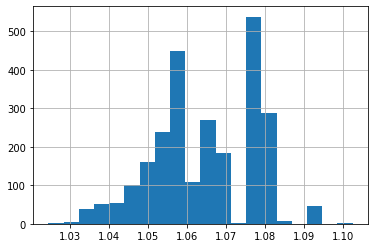

In [17]:
# Ensure that the total prob is always > 1
%matplotlib inline

assert odds['total_threshold_prob'].min() > 1
odds['total_threshold_prob'].hist(bins=20)

In [18]:
odds['winner_implied_prob'] = odds['winner_threshold_prob'] / odds['total_threshold_prob']
odds['loser_implied_prob'] = 1. - odds['winner_implied_prob']

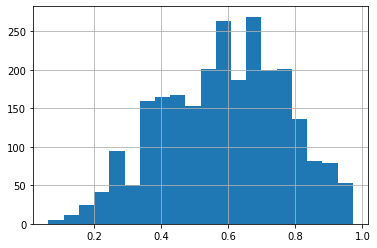

In [21]:
assert (odds['winner_implied_prob'] < odds['winner_threshold_prob']).all()
odds['winner_implied_prob'].hist(bins=20)

In [22]:
# How many matches in 2018 in total?
(jd['year'] == 2018).sum()

12784

In [23]:
# How many ATP matches?
jd_2018 = jd[jd['year'] == 2018]
jd_2018['tour_type'].value_counts()

challenger    8826
atp           3958
Name: tour_type, dtype: int64

In [24]:
odds_cols = [x for x in odds if x not in jd] + ['match_id']
sorted(odds_cols)

['ATP',
 'AvgL',
 'AvgW',
 'B365L',
 'B365W',
 'Best of',
 'Comment',
 'Court',
 'Date',
 'EXL',
 'EXW',
 'L1',
 'L2',
 'L3',
 'L4',
 'L5',
 'LBL',
 'LBW',
 'LPts',
 'LRank',
 'Location',
 'Loser',
 'Lsets',
 'MaxL',
 'MaxW',
 'PSL',
 'PSW',
 'Round',
 'Series',
 'Surface',
 'Tournament',
 'W1',
 'W2',
 'W3',
 'W4',
 'W5',
 'WPts',
 'WRank',
 'Winner',
 'Wsets',
 'loser_implied_prob',
 'loser_last_name',
 'loser_threshold_prob',
 'match_id',
 'odds_match_id',
 'total_threshold_prob',
 'winner_implied_prob',
 'winner_last_name',
 'winner_threshold_prob']

In [25]:
jd_odds = pd.merge(
    jd,
    odds[odds_cols],
    on='match_id',
    how='left'
)

In [26]:
# How many matches missing odds?
jd_odds['odds_match_id'].notnull().value_counts()

False    370693
True       2543
Name: odds_match_id, dtype: int64

In [27]:
missing = jd_odds[
    (jd_odds['tour_type'] == 'atp') &
    (jd_odds['year'] == 2018) &
    (jd_odds['odds_match_id'].isnull())
]

In [28]:
pd.set_option('display.max_rows', 100000)

top_tourneys = missing[missing['tourney_title'].isin(missing['tourney_title'].value_counts().head(20).index)]
top_tourneys.groupby('tourney_title').apply(
    lambda x: x['round'].value_counts()
)

tourney_title                                      
ATP Masters 1000 Canada        1st Round Qualifying    14
                               2nd Round Qualifying     7
                               Round of 64              1
ATP Masters 1000 Cincinnati    1st Round Qualifying    14
                               2nd Round Qualifying     7
                               Semi-Finals              1
ATP Masters 1000 Indian Wells  1st Round Qualifying    24
                               2nd Round Qualifying    12
                               Round of 32              2
                               Round of 16              1
                               Round of 64              1
                               Round of 128             1
ATP Masters 1000 Madrid        1st Round Qualifying    14
                               2nd Round Qualifying     7
ATP Masters 1000 Miami         1st Round Qualifying    24
                               2nd Round Qualifying    12
ATP Masters 1000 Mon

It looks like most cases with the odds missing are very early rounds in the tournament.  Our hunch is that the rest of them are retiree matches...

In [29]:
# Check that other cases are all retires 
# TODO: More rigorous check
missing[missing['round'] == 'Round of 128']['score'].head(100)

351592             62;41 (RET)
353283             63;21 (RET)
356308                61;64;76
356347             36;34 (RET)
356357             61;20 (RET)
357704          64;75;20 (RET)
360119             63;34 (RET)
360125          75;61;11 (RET)
360141       46;76;60;20 (RET)
360146          75;57;41 (RET)
360150    76;67;46;61;41 (RET)
360151       64;64;26;31 (RET)
360156       64;64;46;21 (RET)
360161       62;26;76;30 (RET)
360178       67;64;62;21 (RET)
Name: score, dtype: object

There are a few other missing cases -- we'll deal with these later...

In [30]:
SURFACE = 'Hard'

has_odds = jd_odds[
    jd_odds['odds_match_id'].notnull() &
    (jd_odds['tourney_surface'] == SURFACE)
].copy()

In [31]:
# How many matches are missing?
has_odds['tourney_title'].value_counts().head()

Australian Open                  123
US Open                          114
ATP Masters 1000 Miami            95
ATP Masters 1000 Indian Wells     90
ATP Masters 1000 Shanghai         54
Name: tourney_title, dtype: int64

In [32]:
# How good is each casino?
CASINOS = [
    'B365',
    'Avg',
    'EX',
    'LB',
    'Max',
    'PS',
]
rel = jd_odds[
    jd_odds[
        ['%sL' % casino for casino in CASINOS] + 
        ['%sW' % casino for casino in CASINOS]
    ].notnull().all(axis=1) &
    (jd_odds['tourney_surface'] == 'Hard')
]
for casino in CASINOS:
    acc = ((rel['%sL' % casino] >= rel['%sW' % casino]).mean())
    print(casino, acc)

B365 0.6930193439865433
Avg 0.6820857863751051
EX 0.6921783010933558
LB 0.695542472666106
Max 0.6812447434819175
PS 0.6837678721614803


PS is the worst bookie.  B365 is pretty good - we'll continue to measure against them!

In [33]:
# B365 Accuracy on matches where B365 is not null
{
    'B365 Cheating Accuracy': (has_odds['B365L'] >= has_odds['B365W']).mean(),
    'B365 Pessimistic Accuracy': (has_odds['B365L'] > has_odds['B365W']).mean(),
    'ELO Accuracy': (has_odds['elo_match_prediction'] > 0.5).mean(),
    'Rank Accuracy': (has_odds['LRank'] > has_odds['WRank']).mean()
}

{'B365 Cheating Accuracy': 0.700836820083682,
 'B365 Pessimistic Accuracy': 0.6806136680613668,
 'ELO Accuracy': 0.6687587168758717,
 'Rank Accuracy': 0.6499302649930265}

In [34]:
not_even = has_odds[
    (has_odds['B365L'] != has_odds['B365W'])
]
{
    'B365 Accuracy': (not_even['B365L'] > not_even['B365W']).mean(),
    'ELO Accuracy': (not_even['elo_match_prediction'] > 0.5).mean(),
    'Rank Accuracy': (not_even['LRank'] > not_even['WRank']).mean()
}

{'B365 Accuracy': 0.6946619217081851,
 'ELO Accuracy': 0.6718861209964413,
 'Rank Accuracy': 0.6512455516014235}

We do see an improvement from not training on matches with retirements, but not from removing walkovers.  We do decidedely outdo the ATP rankings, thankfully...

In [35]:
# How many even odds matches are there?
even = has_odds[has_odds['B365L'] == has_odds['B365W']]
even.shape[0]

29

In [36]:
# How often do we get things right with even odds?
(even['elo_match_prediction'] > 0.5).value_counts()

True     15
False    14
Name: elo_match_prediction, dtype: int64

In [37]:
# Z-test for above cases...is it a fluke?
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(
    (even['elo_match_prediction'] > 0.5).sum(),
    even.shape[0],
    0.5,
    'larger'
)

(0.185805838239302, 0.4262985130046936)

Could be, but we'd have to be relatively lucky...

#### Error Analysis

Let's take a look at the matches where the ELO model makes its most egregious errors -- perhaps this will reveal opportunities to improve the model!

In [40]:
errors = has_odds[
    (has_odds['elo_match_prediction'] < 0.5) &  # We're wrong
    (has_odds['winner_implied_prob'] > 0.5)  # Odds thought eventual outcome was very likely
].copy()

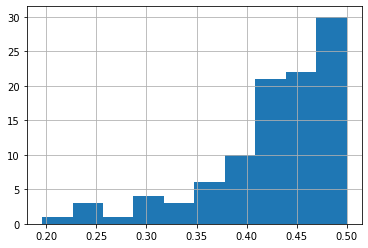

In [41]:
%matplotlib inline

errors['elo_match_prediction'].hist(bins=10)

At least when we're wrong, we're usually pretty close to right

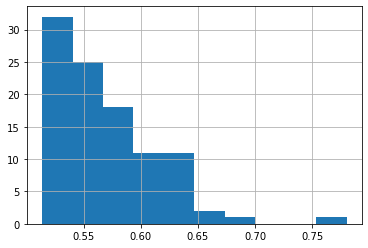

In [44]:
errors['winner_implied_prob'].hist(bins=10)

In [43]:
errors[[
    'B365W',
    'B365L',
    'elo_match_prediction',
    'winner_name',
    'loser_name'
]].head()

,B365W,B365L,elo_match_prediction,winner_name,loser_name
351007,1.53,2.37,0.454470,Hyeon Chung,Gilles Muller
351017,1.66,2.10,0.384041,Michael Mmoh,Federico Delbonis
351029,1.72,2.10,0.319733,Alex de Minaur,Michael Mmoh
351120,1.72,2.00,0.458860,Borna Coric,Pablo Carreno Busta
351143,1.36,3.00,0.425855,Nicolas Jarry,Pablo Andujar


In [45]:
errors.sort_values('implied_prob', ascending=False, inplace=True)
errors[[
    'B365W',
    'B365L',
    'elo_match_prediction',
    'elo1',
    'elo2',
    'winner_name',
    'loser_name',
    'winner_implied_prob',
    'Date'
]].head()

KeyError: 'implied_prob'

In [46]:
from matplotlib import pyplot as plt

PRINT_COLS = ['tourney_dates', 'winner_name', 'loser_name', 'elo1', 'elo2', 'elo']


def _get_player_df(pid):
    rel = jd[
        (jd['winner_id'] == pid) |
        (jd['loser_id'] == pid)
    ].copy()
    rel['elo'] = rel['elo1']
    rel.loc[jd['loser_id'] == pid, 'elo'] = rel.loc[
        jd['loser_id'] == pid, 'elo2'
    ]
    rel['tourney_dates'] = pd.to_datetime(rel['tourney_dates'])
    rel['elo_diff'] = rel['elo'].diff().shift(-1)
    rel['elo_abs_diff'] = rel['elo_diff'].abs()
    return rel



def investigate_match(match_row):
    print(match_row[[
        'winner_name',
        'loser_name',
        'tourney_title',
        'score',
        'elo1',
        'elo2',
        'elo_match_prediction',
        'winner_implied_prob',
        'Date'
    ]].to_string())
    wid = match_row['winner_id']
    lid = match_row['loser_id']
    wdf = _get_player_df(wid)
    ldf = _get_player_df(lid)
    rel_wdf = wdf[wdf['tourney_dates'] > pd.to_datetime('2015.01.01')]  # TODO: Unhardcode
    rel_ldf = ldf[ldf['tourney_dates'] > pd.to_datetime('2015.01.01')]  # TODO: Unhardcode

    tourneys = rel_wdf.groupby('tourney_year_id').apply(
        lambda x: pd.Series({
            'tourney_name': x['tourney_title'].iloc[0],
            'total_elo_diff': x['elo_diff'].sum(),
            'tourney_dates': x['tourney_dates'].iloc[0],
            'tourney_surface': x['tourney_surface'].iloc[0]
        })
    )
    print("WINNER BEST TOURNEYS: \n")
    print(tourneys.sort_values('total_elo_diff', ascending=False).head(5))
    
    
    
    print("WINNER: \n")
    print(wdf[wdf['tourney_dates'] <= match_row['tourney_dates']][PRINT_COLS].tail(50).to_string())
    print("WINNER BIG DIFFS: \n")
    big_diffs = rel_wdf.sort_values('elo_abs_diff', ascending=False).head(5)  # TODO: Unhardcode
    print(big_diffs[PRINT_COLS].to_string())
    
    print("LOSER: \n")
    print(ldf[ldf['tourney_dates'] <= match_row['tourney_dates']][PRINT_COLS].tail(50).to_string())
    print("LOSER BIG DIFFS: \n")
    big_diffs = rel_ldf.sort_values('elo_abs_diff', ascending=False).head(5)  # TODO: Unhardcode
    print(big_diffs[PRINT_COLS].to_string())

    plt.plot(
        pd.to_datetime(rel_wdf['tourney_dates']), rel_wdf['elo']
    )
    
    plt.plot(
        pd.to_datetime(rel_ldf['tourney_dates']), rel_ldf['elo']
    )
    plt.vlines(
        pd.to_datetime(match_row['Date']),
        min(rel_wdf['elo'].min(), rel_ldf['elo'].min()),
        max(rel_wdf['elo'].max(), rel_ldf['elo'].max()),
        linestyles='dashed',
        colors='red'
    )

winner_name                  Michael Mmoh
loser_name              Federico Delbonis
tourney_title                    Brisbane
score                               63;64
elo1                              1902.77
elo2                              1984.84
elo_match_prediction             0.384041
winner_implied_prob              0.558511
Date                               1/2/18
WINNER BEST TOURNEYS: 

                tourney_name  total_elo_diff tourney_dates tourney_surface
tourney_year_id                                                           
2016_1768            Tiburon      138.419453    2016-09-26            Hard
2015_7345          Las Vegas      123.834567    2015-10-19            Hard
2016_363           Knoxville      115.377456    2016-11-08            Hard
2016_6708               Maui      110.994977    2016-01-25            Hard
2017_586           Lexington       80.999985    2017-07-31            Hard
WINNER: 

       tourney_dates          winner_name           loser_name 

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


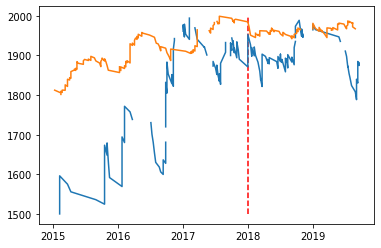

In [47]:
investigate_match(errors.iloc[1])

Many of our errors are when a player hasn't played in a long time...

#### Calibration Analysis

Let's see how well calibrated our model is!

In [48]:
# TODO: Rename variables here for readability
w = jd[
    (jd['tourney_dates'] > '2015.01.01') &
    (jd['tourney_surface'] == "Hard") &
    (jd['elo_match_prediction'].notnull())
].copy()

In [114]:
w['best_of'] = w['tourney_title'].map(
    lambda x: 5 if x in ('US Open', 'Australian Open') else 3  # Hardcoded
)

For assessing calibration, we'll include every point with both definitions of 0 / 1, rather than randomizing which player is "home" and "away".  This reduces noise.

In [115]:
w['y'] = 1
# w['pred'] = w['implied_prob']
w['pred'] = w['elo_match_prediction']
reverse = w.copy()
reverse['pred'] = 1. - w['elo_match_prediction']
reverse['y'] = 0
calibrate_df = pd.concat([
    w, reverse
])

In [116]:
calibrate_df['random_pred'] = np.random.uniform(0, 1, size=calibrate_df.shape[0])

In [117]:
calibrate_df.shape

(59452, 35)

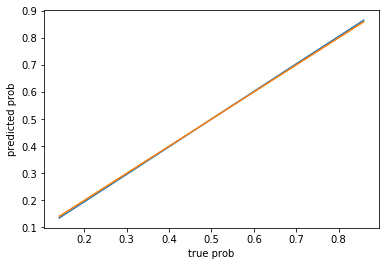

In [118]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt

def plot_calibration_curve(df, pred_col, n_points=50):
    _x, _y = calibration_curve(df['y'], df[pred_col], 50)
    plt.plot(_x, _y)
    plt.plot(_x, _x)
    plt.xlabel('true prob')
    plt.ylabel('predicted prob')

plot_calibration_curve(calibrate_df, 'pred')

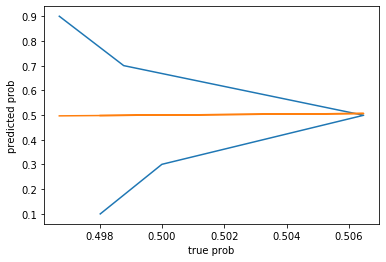

In [119]:
plot_calibration_curve(calibrate_df, 'random_pred')

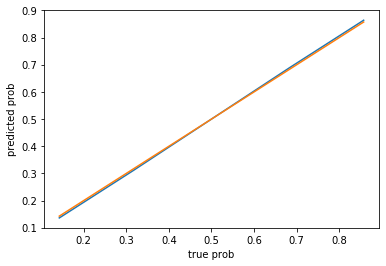

In [120]:
plot_calibration_curve(calibrate_df[calibrate_df['best_of'] == 3], 'pred')

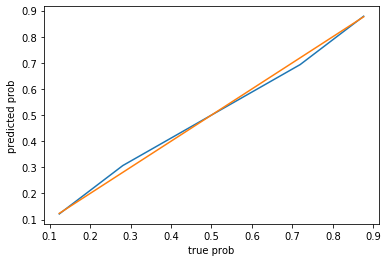

In [123]:
plot_calibration_curve(calibrate_df[calibrate_df['best_of'] == 5], 'pred', n_points=20)

Pretty well calibrated already on 3 set matches -- not as good on 5 set matches.  Let's see how we'd do on 3 set matches...

In [46]:
from sklearn.isotonic import IsotonicRegression 

iso = IsotonicRegression()
iso.fit(calibrate_df['pred'], calibrate_df['y'])

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None, y_min=None)

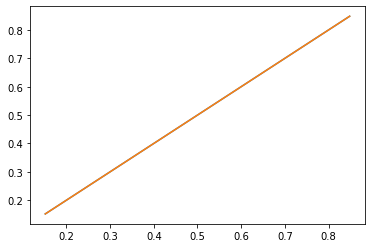

In [47]:
calibrated = iso.predict(calibrate_df['pred'].values)
verify_x, verify_y = calibration_curve(calibrate_df['y'].values, calibrated, 20)
plt.plot(verify_x, verify_y)
plt.plot(verify_x, verify_x)

Good, calibrated!

#### How does our model do? 

In [402]:
to_bet = has_odds[
    (has_odds['Best of'] == 3)
].copy().sort_values('Date', ascending=True)

In [403]:
def attempt_strategy(strategy, n_bootstraps=1000, df=to_bet):
    returns = df.apply(strategy, axis=1)
    with_bet = returns[returns != 0]
    total_return = with_bet.mean()
    bootstrapped_return = []
    for _ in range(n_bootstraps):
        bootstrapped_return.append(with_bet.sample(n=with_bet.shape[0], replace=True).mean())
    pd.Series(bootstrapped_return).hist(bins=20)
    return total_return, pd.Series(bootstrapped_return)

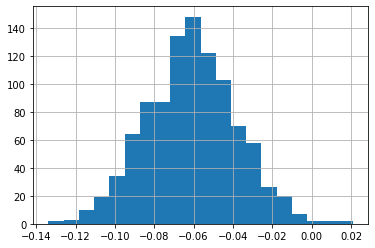

In [404]:
# How does always betting on the rank favorite do?
def rank_bet(x):
    if pd.isnull(x['WRank']) or pd.isnull(x['LRank']):
        return 0. 
    if x['WRank'] < x['LRank']:
        return x['B365W'] - 1.
    else:
        return -1. 

rank_mean, rank_boot = attempt_strategy(rank_bet)

In [405]:
rank_mean

-0.06031772575250835

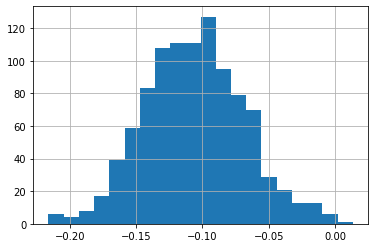

In [406]:
# Rank underdog?
def rank_bet(x):
    if pd.isnull(x['WRank']) or pd.isnull(x['LRank']):
        return 0. 
    if x['WRank'] > x['LRank']:
        return x['B365W'] - 1.
    else:
        return -1. 

rank_mean, rank_boot = attempt_strategy(rank_bet)

In [407]:
rank_mean

-0.10464046822742473

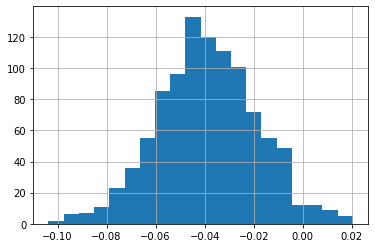

In [408]:
# How do we do if we always bet on the odds favorite?
def odds_favorite_bet(x):
    if x['B365W'] < x['B365L']:
        return x['B365W'] - 1.
    elif x['B365L'] < x['B365W']:
        return -1.
    else:
        return 0.

odds_favorite_mean, odds_favorite_boot = attempt_strategy(odds_favorite_bet)

In [409]:
odds_favorite_mean

-0.03956911262798634

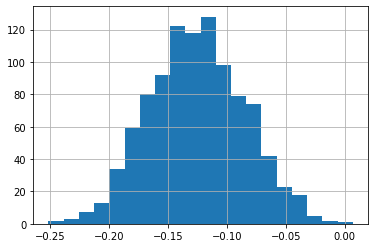

In [410]:
# How do we do if we always bet on the odds favorite?
def odds_underdog_bet(x):
    if x['B365W'] > x['B365L']:
        return x['B365W'] - 1.
    elif x['B365L'] > x['B365W']:
        return -1.
    else:
        return 0.

odds_underdog_mean, odds_underdog_boot = attempt_strategy(odds_underdog_bet)

In [411]:
odds_underdog_mean

-0.12616894197952216

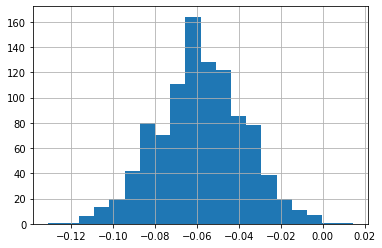

In [412]:
# How do we do if we always bet on my model's favorite?
def model_favorite_bet(x):
    if x['elo_match_prediction'] > 0.5:
        return x['B365W'] - 1.
    elif x['elo_match_prediction'] < 0.5:
        return -1.
    else:
        return 0.

model_favorite_mean, model_favorite_boot = attempt_strategy(model_favorite_bet)

In [413]:
model_favorite_mean

-0.05780701754385964

A little better than the rank favorite model.  What if we only bet on the favorite when a certain margin was achieved?

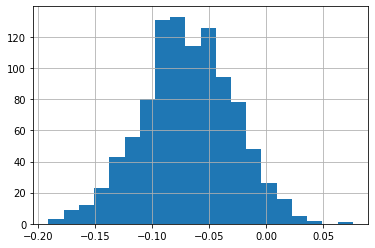

In [414]:
def odds_favorite_threshold_bet(x, margin=0.01):
    if x['B365W'] < x['B365L']:
        if x['elo_match_prediction'] > x['winner_threshold_prob'] + margin:
            return x['B365W'] - 1.
    elif x['B365L'] < x['B365W']:
        if (1. - x['elo_match_prediction']) > x['loser_threshold_prob'] + margin:
            return -1.
    else:
        return 0.

tof_mean, tof_boot = attempt_strategy(odds_favorite_threshold_bet)

In [415]:
tof_mean

-0.06921135646687697

Applying our threshold makes things worse!

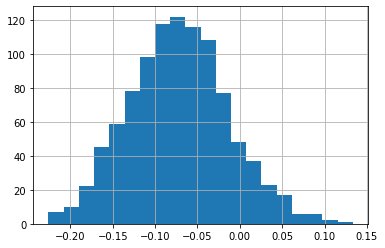

In [416]:
def threshold_bet(x, margin_low=0.01, margin_high=0.05):
    if margin_high > (x['elo_match_prediction'] - x['winner_threshold_prob']) > margin_low:
            return x['B365W'] - 1.
    elif margin_high > (1. - x['elo_match_prediction'] - x['loser_threshold_prob']) > margin_low:
            return -1.
    else:
        return 0.

thresh_mean, thresh_boot = attempt_strategy(threshold_bet)

In [418]:
thresh_mean

-0.06762611275964389

In [391]:
to_bet['winner_margin'] = to_bet['elo_match_prediction'] - to_bet['winner_threshold_prob']
to_bet['loser_margin'] = (1. - to_bet['elo_match_prediction']) - to_bet['loser_threshold_prob']
to_bet['bet_margin'] = to_bet[['winner_margin', 'loser_margin']].max(axis=1)

In [277]:
assert not (
    (to_bet['winner_margin'] > 0) &
    (to_bet['loser_margin'] > 0)
).any()

In [279]:
to_bet['margin_gp'] = pd.qcut(to_bet['bet_margin'], 20)

In [283]:
to_bet.groupby('margin_gp').apply(lambda x: )

margin_gp
(-0.0438, -0.0297]                      (72, nan)
(-0.0297, -0.0217]                      (72, nan)
(-0.0217, -0.0169]                      (71, nan)
(-0.0169, -0.0121]                      (72, nan)
(-0.0121, -0.00662]                     (72, nan)
(-0.00662, -0.00158]                    (71, nan)
(-0.00158, 0.00491]       (72, 0.510000000000002)
(0.00491, 0.0107]        (72, 12.090000000000002)
(0.0107, 0.0175]                     (71, -15.92)
(0.0175, 0.0234]         (72, 13.050000000000004)
(0.0234, 0.031]                        (72, -9.7)
(0.031, 0.0382]         (71, -16.689999999999998)
(0.0382, 0.047]         (72, -17.179999999999996)
(0.047, 0.0561]                        (72, -9.6)
(0.0561, 0.068]                      (71, -13.47)
(0.068, 0.0803]         (72, -17.240000000000002)
(0.0803, 0.098]                      (72, -12.07)
(0.098, 0.12]            (71, -6.029999999999999)
(0.12, 0.144]            (72, -4.699999999999999)
(0.144, 0.402]           (72, -7.6699999

Let's look at some of the players we bet on most...

In [478]:
PRED_COL = 'elo_match_prediction'  # TODO: Calibrate? 
# PRED_COL = 'calibrated_pred'  # NOTE: Cheating! 

def _get_bet(row, buffer_low=0.01, buffer_high=0.05):
    if (row['winner_threshold_prob'] + buffer_high) > row[PRED_COL] > (row['winner_threshold_prob'] + buffer_low):
        return row['B365W'] - 1., row['winner_name'], row['loser_name']
    elif (row['loser_threshold_prob'] + buffer_high) > (1. - row[PRED_COL]) >  (row['loser_threshold_prob'] + buffer_low):
        return -1., row['loser_name'], row['winner_name'] 
    else:
        return None, None, None

to_bet = has_odds[has_odds['Best of'] == 3].copy()
bet_summaries = to_bet.apply(_get_bet, axis=1).tolist()
to_bet['return'] = list(zip(*bet_summaries))[0]
to_bet['player_bet_on'] = list(zip(*bet_summaries))[1]
to_bet['player_bet_against'] = list(zip(*bet_summaries))[2]

In [479]:
to_bet['player_bet_on'].value_counts().head()

Daniil Medvedev          12
Juan Martin del Potro    10
Albert Ramos-Vinolas      9
Hyeon Chung               7
Robin Haase               7
Name: player_bet_on, dtype: int64

In [480]:
to_bet['player_bet_against'].value_counts().head()

Borna Coric         10
Gilles Simon         9
Sam Querrey          9
Marton Fucsovics     9
Yuichi Sugita        8
Name: player_bet_against, dtype: int64

In [482]:
player_involvement = to_bet['player_bet_on'].value_counts() + to_bet['player_bet_against'].value_counts()

In [484]:
player_involvement.sort_values(ascending=False).head()

Daniil Medvedev          14.0
Gilles Simon             13.0
Juan Martin del Potro    12.0
Pierre-Hugues Herbert    12.0
Roberto Bautista Agut    12.0
dtype: float64

In [486]:
to_look = to_bet[
    to_bet['return'].notnull() &
    (
        (to_bet['player_bet_on'] == 'Daniil Medvedev') |
        (to_bet['player_bet_against'] == 'Daniil Medvedev')
    )
]

In [489]:
to_look[[
    'winner_threshold_prob',
    'loser_threshold_prob',
    'winner_name',
    'loser_name',
    'elo_match_prediction',
    'return',
    'loser_id',
    'player_bet_on'
]]

,winner_threshold_prob,loser_threshold_prob,winner_name,loser_name,elo_match_prediction,return,loser_id,player_bet_on
351305,0.666667,0.381679,Daniil Medvedev,Paolo Lorenzi,0.581686,-1,l503,Paolo Lorenzi
352494,0.500000,0.555556,Andreas Seppi,Daniil Medvedev,0.403164,-1,mm58,Daniil Medvedev
353280,0.526316,0.555556,Daniil Medvedev,Steve Johnson,0.554141,0.9,j386,Daniil Medvedev
353661,0.581395,0.500000,Daniil Medvedev,Stefanos Tsitsipas,0.615738,0.72,te51,Daniil Medvedev
359560,0.877193,0.181818,Alexander Zverev,Daniil Medvedev,0.779002,-1,mm58,Daniil Medvedev
359666,0.714286,0.363636,Borna Coric,Daniil Medvedev,0.597520,-1,mm58,Daniil Medvedev
359983,0.751880,0.294118,Daniil Medvedev,Guido Andreozzi,0.788178,0.33,a887,Daniil Medvedev
359989,0.694444,0.363636,Daniil Medvedev,Taro Daniel,0.741019,0.44,da81,Daniil Medvedev
361178,0.653595,0.400000,Dominic Thiem,Daniil Medvedev,0.559135,-1,mm58,Daniil Medvedev
361696,0.581395,0.500000,Daniil Medvedev,Martin Klizan,0.620026,0.72,k966,Daniil Medvedev


In [492]:
to_bet.sort_values('return', ascending=False)[[
    'winner_threshold_prob',
    'loser_threshold_prob',
    'winner_name',
    'loser_name',
    'elo_match_prediction',
    'return',
    'loser_id',
    'player_bet_on'
]]

,winner_threshold_prob,loser_threshold_prob,winner_name,loser_name,elo_match_prediction,return,loser_id,player_bet_on
363415,0.181818,0.877193,Alexander Zverev,Novak Djokovic,0.199794,4.5,d643,Alexander Zverev
359231,0.200000,0.862069,Egor Gerasimov,Sam Querrey,0.227431,4,q927,Egor Gerasimov
361838,0.200000,0.862069,Matthew Ebden,Dominic Thiem,0.211072,4,tb69,Matthew Ebden
359946,0.230947,0.833333,Roberto Carballes Baena,Guido Pella,0.248321,3.33,pc11,Roberto Carballes Baena
359944,0.250000,0.819672,Guido Andreozzi,Marton Fucsovics,0.286625,3,f724,Guido Andreozzi
361844,0.250000,0.819672,Marco Cecchinato,Hyeon Chung,0.264813,3,ch27,Marco Cecchinato
352946,0.250000,0.819672,Matthew Ebden,Sam Querrey,0.269286,3,q927,Matthew Ebden
353671,0.250000,0.819672,Mikael Ymer,Jan-Lennard Struff,0.270320,3,sl28,Mikael Ymer
361577,0.266667,0.800000,Feliciano Lopez,Borna Coric,0.316349,2.75,cg80,Feliciano Lopez
361816,0.266667,0.800000,Marco Cecchinato,Gilles Simon,0.299291,2.75,sd32,Marco Cecchinato


In [490]:
player_returns = to_bet.groupby('player_bet_on').apply(
    lambda x: (x['return'] < 0).sum()
)

In [459]:
to_bet['player'].value_counts()

Daniil Medvedev            12
Juan Martin del Potro      10
Albert Ramos-Vinolas        9
Hyeon Chung                 7
Robin Haase                 7
Roberto Bautista Agut       7
Alex de Minaur              7
Peter Gojowczyk             7
Grigor Dimitrov             7
Matthew Ebden               7
Kei Nishikori               6
Pierre-Hugues Herbert       6
Lucas Pouille               6
Feliciano Lopez             6
Novak Djokovic              6
Dominic Thiem               6
Roger Federer               6
Fabio Fognini               6
Richard Gasquet             6
Pablo Carreno Busta         5
Stefanos Tsitsipas          5
Steve Johnson               5
Viktor Troicki              5
Marco Cecchinato            5
Adrian Mannarino            5
Stan Wawrinka               4
Kevin Anderson              4
Frances Tiafoe              4
Nick Kyrgios                4
Mischa Zverev               4
Taro Daniel                 4
Jan-Lennard Struff          4
Filip Krajinovic            4
Mikhail Yo

In [460]:
player_returns.sort_values(ascending=True)

player
Karen Khachanov            0
Federico Delbonis          0
Mikael Ymer                0
Gael Monfils               0
Liam Broady                0
Egor Gerasimov             0
Dudi Sela                  0
Novak Djokovic             0
Dominic Thiem              0
Guido Andreozzi            0
Rafael Nadal               0
Roberto Carballes Baena    0
Guido Pella                0
Horacio Zeballos           0
Bernard Tomic              0
Sam Querrey                0
Andrey Rublev              0
Vincent Millot             0
Yannick Maden              0
Maximilian Marterer        0
Mackenzie McDonald         1
Kei Nishikori              1
Kyle Edmund                1
Laslo Djere                1
Jurgen Zopp                1
Juan Martin del Potro      1
Jo-Wilfried Tsonga         1
Lukas Lacko                1
Kevin Anderson             1
Nikoloz Basilashvili       1
Michael Mmoh               1
Mikhail Kukushkin          1
Nicolas Kicker             1
Jiri Vesely                1
Paolo L

In [469]:
to_bet[to_bet['player'] == 'Peter Gojowczyk'][[
    'winner_threshold_prob',
    'loser_threshold_prob',
    'winner_name',
    'loser_name',
    'elo_match_prediction',
    'return',
    'loser_id'
]]

,winner_threshold_prob,loser_threshold_prob,winner_name,loser_name,elo_match_prediction,return,loser_id
352793,0.666667,0.400000,Peter Gojowczyk,Reilly Opelka,0.690938,0.5,o522
353662,0.636943,0.444444,John Millman,Peter Gojowczyk,0.513744,-1,g967
359976,0.666667,0.381679,Pablo Carreno Busta,Peter Gojowczyk,0.595919,-1,g967
361575,0.694444,0.381679,Kyle Edmund,Peter Gojowczyk,0.598631,-1,g967
361812,0.476190,0.602410,Peter Gojowczyk,Jack Sock,0.489443,1.1,sm25
361856,0.555556,0.500000,Matthew Ebden,Peter Gojowczyk,0.482086,-1,g967
362601,0.581395,0.500000,Peter Gojowczyk,Nicolas Jarry,0.609792,0.72,j551


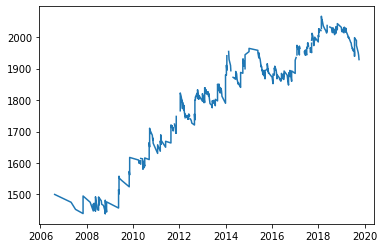

In [470]:
player_df = _get_player_df('g967')
plt.plot(pd.to_datetime(player_df['tourney_dates']), player_df['elo'])

In [422]:
to_bet[[
    'Date', 'winner_name', 'loser_name', PRED_COL, 'winner_implied_prob', 'B365W', 'B365L', 'return', 'total_return'
]]

,Date,winner_name,loser_name,elo_match_prediction,winner_implied_prob,B365W,B365L,return,total_return
351007,1/2/18,Hyeon Chung,Gilles Muller,0.454470,0.607692,1.530,2.37,NaN,NaN
351008,12/31/17,Alexandr Dolgopolov,Diego Schwartzman,0.457317,0.422572,2.200,1.61,NaN,NaN
351009,1/2/18,Denis Istomin,Damir Dzumhur,0.276409,0.354680,2.620,1.44,-1.00,-1.00
351010,1/1/18,Mischa Zverev,John-Patrick Smith,0.766313,0.662651,1.400,2.75,NaN,NaN
351011,12/31/17,Alex de Minaur,Steve Johnson,0.141738,0.337349,2.750,1.40,NaN,NaN
351012,1/1/18,Jared Donaldson,Jordan Thompson,0.492164,0.500000,1.830,1.83,NaN,NaN
351013,1/1/18,Matthew Ebden,Frances Tiafoe,0.425079,0.375000,2.500,1.50,1.50,0.50
351014,1/2/18,Kyle Edmund,Denis Shapovalov,0.624393,0.537634,1.720,2.00,0.72,1.22
351015,1/1/18,Ryan Harrison,Leonardo Mayer,0.601953,0.577428,1.610,2.20,NaN,NaN
351016,1/2/18,John Millman,Peter Polansky,0.671707,0.709607,1.330,3.25,-1.00,0.22


In [424]:
with_bets = to_bet[to_bet['return'].notnull()]
with_bets

,loser_id,loser_name,loser_url,match_stats_url,round,round_order,score,winner_id,winner_name,winner_url,...,AvgW,AvgL,odds_match_id,winner_threshold_prob,loser_threshold_prob,total_threshold_prob,winner_implied_prob,loser_implied_prob,return,total_return
351009,d923,Damir Dzumhur,/en/players/damir-dzumhur/d923/overview,/en/scores/2018/339/MS028/match-stats?isLive=F...,Round of 32,4,67;63;62,i165,Denis Istomin,/en/players/denis-istomin/i165/overview,...,2.53,1.51,10.0,0.381679,0.694444,1.076124,0.354680,0.645320,-1.00,-1.00
351013,td51,Frances Tiafoe,/en/players/frances-tiafoe/td51/overview,/en/scores/2018/339/MS021/match-stats?isLive=F...,Round of 32,4,63;62,e690,Matthew Ebden,/en/players/matthew-ebden/e690/overview,...,2.37,1.58,3.0,0.400000,0.666667,1.066667,0.375000,0.625000,1.50,0.50
351014,su55,Denis Shapovalov,/en/players/denis-shapovalov/su55/overview,/en/scores/2018/339/MS018/match-stats?isLive=F...,Round of 32,4,67;76;64,e831,Kyle Edmund,/en/players/kyle-edmund/e831/overview,...,1.74,2.08,9.0,0.581395,0.500000,1.081395,0.537634,0.462366,0.72,1.22
351016,pb22,Peter Polansky,/en/players/peter-polansky/pb22/overview,/en/scores/2018/339/MS017/match-stats?isLive=F...,Round of 32,4,76;60,mh30,John Millman,/en/players/john-millman/mh30/overview,...,1.33,3.27,11.0,0.751880,0.307692,1.059572,0.709607,0.290393,-1.00,0.22
351022,z168,Mischa Zverev,/en/players/mischa-zverev/z168/overview,/en/scores/2018/339/MS012/match-stats?isLive=F...,Round of 16,3,62;57;64,mp01,Michael Mmoh,/en/players/michael-mmoh/mp01/overview,...,2.40,1.56,14.0,0.421941,0.653595,1.075536,0.392308,0.607692,-1.00,-0.78
351025,h997,Yannick Hanfmann,/en/players/yannick-hanfmann/h997/overview,/en/scores/2018/339/MS015/match-stats?isLive=F...,Round of 16,3,67;64;62,h940,Ryan Harrison,/en/players/ryan-harrison/h940/overview,...,1.34,3.21,17.0,0.735294,0.333333,1.068627,0.688073,0.311927,0.36,-0.42
351028,d801,Alexandr Dolgopolov,/en/players/alexandr-dolgopolov/d801/overview,/en/scores/2018/339/MS005/match-stats?isLive=F...,Quarter-Finals,2,16;63;64,ke17,Nick Kyrgios,/en/players/nick-kyrgios/ke17/overview,...,1.45,2.77,21.0,0.694444,0.363636,1.058081,0.656325,0.343675,0.44,0.02
351119,d864,Evgeny Donskoy,/en/players/evgeny-donskoy/d864/overview,/en/scores/2018/451/MS016/match-stats?isLive=F...,Round of 32,4,76;63,tb69,Dominic Thiem,/en/players/dominic-thiem/tb69/overview,...,1.21,4.26,29.0,0.833333,0.230947,1.064280,0.783002,0.216998,-1.00,-0.98
351120,cd85,Pablo Carreno Busta,/en/players/pablo-carreno-busta/cd85/overview,/en/scores/2018/451/MS031/match-stats?isLive=F...,Round of 32,4,57;62;76,cg80,Borna Coric,/en/players/borna-coric/cg80/overview,...,1.75,2.06,32.0,0.581395,0.500000,1.081395,0.537634,0.462366,-1.00,-1.98
351123,e224,Victor Estrella Burgos,/en/players/victor-estrella-burgos/e224/overview,/en/scores/2018/451/MS019/match-stats?isLive=F...,Round of 32,4,60;62,g628,Richard Gasquet,/en/players/richard-gasquet/g628/overview,...,1.11,6.45,40.0,0.892857,0.166667,1.059524,0.842697,0.157303,0.12,-1.86


In [426]:
with_bets['total_return'].iloc[-1] / with_bets.shape[0]

-0.06762611275964389

In [154]:
wubba = to_bet.copy()
wubba['spread_bin'] = pd.qcut(to_bet['total_threshold_prob'], 5)

In [155]:
# Do we do better when the casino arbitrage is smaller?
wubba.groupby('spread_bin').apply(
    lambda x: (x.shape[0], x['return'].notnull().sum(), x['return'].sum() / x['return'].notnull().sum())
)

spread_bin
(1.0230000000000001, 1.058]              (250, 80, -0.195625)
(1.058, 1.067]                 (277, 78, 0.15333333333333335)
(1.067, 1.076]                  (208, 58, 0.1770689655172414)
(1.076, 1.079]                 (261, 69, -0.5210144927536232)
(1.079, 1.103]                 (201, 52, 0.12653846153846154)
dtype: object

Doesn't really look like we do better when the casino arbitrage is smaller...

In [156]:
with_bets = to_bet[
    to_bet['return'].notnull()
].copy()
with_bets['date'] = pd.to_datetime(with_bets['Date'])
with_bets.sort_values('date', inplace=True)
(with_bets['return'] > 0).mean()

0.5014836795252225

We win 50.1% of our bets

In [157]:
with_bets[['winner_implied_prob', 'loser_implied_prob', 'return']].apply(
    lambda x: x['winner_implied_prob'] if x['return'] > 0 else x['loser_implied_prob'],
    axis=1
).mean()

0.4942106556995486

At the implied probabilities of the odds, we should win 49.4% of our bets.

In [158]:
with_bets[['elo_match_prediction', 'return']].apply(
    lambda x: x['elo_match_prediction'] if x['return'] > 0 else 1. - x['elo_match_prediction'],
    axis=1
).mean()

0.5567543584980227

If my model was right, we would win 55.7% of our bets

How often do we bet on the favorite?

In [159]:
has_favorite = with_bets['B365W'] != with_bets['B365L']
rel = with_bets[has_favorite].copy()
rel['bet_on_winner'] = (rel['elo_match_prediction'] > rel['winner_threshold_prob'])
rel['favorite_won'] = rel['B365W'] < rel['B365L']
rel.groupby(['bet_on_winner', 'favorite_won']).size()

bet_on_winner  favorite_won
False          False            47
               True            119
True           False            57
               True            107
dtype: int64

In [160]:
(107. + 47., 119. + 57.)

(154.0, 176.0)

In [161]:
154. / (176. + 154.)

0.4666666666666667

We bet on the underdog 53.3% of the time that we bet...how would a random betting machine work?

In [162]:
with_bets['total_return'].iloc[-1] / with_bets.shape[0]

-0.06762611275964389

-6.8% return according to my strategy, what do you get by randomly selecting bets (betting 1$ on both sides for all bets)?  Let's try to figure it out by seeing what happens when we bet both sides of every match

In [218]:
n_bets = to_bet.shape[0]
bet_both_returns = (to_bet['B365W'] - 2.)

In [220]:
to_bet.shape

(1197, 81)

In [219]:
(bet_both_returns / 2.).sum() / n_bets

-0.08282581453634084

-8.3% return, so my return is better than random...but did I just get lucky?  To figure this out, let's randomly sample the same number of bets I placed...

In [207]:
import numpy as np

all_returns = []
for trial in range(10000):
    random_matches = to_bet.sample(with_bets.shape[0])
    side_of_bet = np.random.choice([0, 1], size=random_matches.shape[0])
    returns = random_matches['B365W'].values * side_of_bet - 1.
    all_returns.append(returns.sum())

In [208]:
b_returns = pd.Series(all_returns)
(b_returns > -22.79).mean()

0.3943

In [227]:
b_returns.mean() / with_bets.shape[0]

-0.08269796142433235

In [241]:
(b_returns / with_bets.shape[0] > 0).mean()

0.0808

You make money 8% of the time if you take random bets as many times as we did...

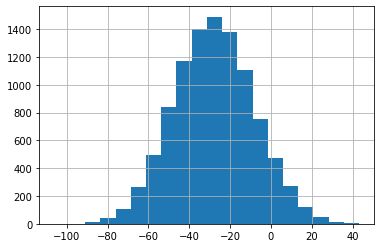

In [228]:
b_returns.hist(bins=20)

In [230]:
b_returns.quantile(0.975) / with_bets.shape[0]

0.03427448071216616

Our performance is better than the random average, but not significantly better.  I would have to have 3.4% returns to have significance at a 95% level.  Let's confirm this analytically...TODO: Confirm this analytically instead of only using the bootstrap 